### Intruduction

The Notebook tries to improve the models of https://github.com/jomjol/neural-network-autotrain-digital-counter

#### Review of the current models

The models are small CNN models to run on edge-AI device ESP32-cam. The dataset is very small with round about 1000 images.

In the autotrain script the models will be trained multiple times with the same dataset. Because of the shuffling the complete dataset will be used as train data. With only one run the training achieves not the 99% accuracy.

Thats why the notebooks tries to creates a small, but better model.

### Mixed datasets

Because zifferdata is a very small dataset, char74k will be used to raise up the count of input images.

http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

chars74 has a small set of numbers (and letters) obtained from natural images. It has also a larger dataset of computer fonts.




### Transfer learning not used (why)

Because of the NaN-category i tried to train first the numbers 0-9 and using transfer learning with fine tune, described here https://keras.io/guides/transfer_learning/. This i tried at first with no success. 

### Knowledge Distillation

To reach >99% on a smal model i tried here knowledge distillation (https://keras.io/examples/vision/knowledge_distillation/ ). It uses a bigger teachner model to train a smaller (edgeAI) student model.

### Training steps


Now the data of ziffer_raw and the two chars74k datasets will be mixed for the first training.

In a second step only the ziffer_raw data will be uses (the same validation-split is here needed to ensure that train and validation every time the same).

First we learn with a dataset like described above. If the learning reaches >99% in a second step the smaller ziffer dataset will be trained again. Here only the last (two) layer will be trained with a lower learning-rate to avoid overfitting.


A third step is a fine tune step with much less learning-rate but all layers will be trained.

The training of every step will be stopped before the model is overfitted. (Validation-Loss is much higher than training loss).


### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "knd"      # Used for tflite Filename
Training_Percentage = 0.2           
Epoch_Anz = 80
nb_classes = 11                     # move to 1. step
input_shape = (32, 20,3)

##########################################################################


In [2]:
# imports

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
#from tensorflow.keras.utils import to_categorical


%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)



In [3]:
# import data methods
import numpy as np
from PIL import Image 
from pathlib import Path
import tensorflow_datasets as tfds
import glob
import os
from tensorflow.keras.utils import get_file

def ziffer_data_files():
    dataset_ziffer_url = "https://github.com/jomjol/neural-network-autotrain-digital-counter/archive/refs/heads/main.zip"
    
    #ziffer_dir = get_file(origin=dataset_ziffer_url,
    #                        fname='neural-network-autotrain-digital-counter-main.zip',
    #                        archive_format='zip',
    #                        extract=True)
    #remove .zip                        
    #ziffer_dir = ziffer_dir[:-4]
    #return glob.glob(ziffer_dir + '/ziffer_raw/*.jpg')
    Input_dir='../ziffer_raw'
    return  glob.glob(Input_dir + '/*.jpg')

    



# load all data
def ziffer_data(x_data, y_data, nb_classes):

    files = ziffer_data_files()

    for aktfile in files:
        base = os.path.basename(aktfile)
        target = base[0:1]
        if target == "N":
            category = 10                # NaN does not work --> convert to 10

        else:
            category = int(target)
        test_image = Image.open(aktfile).resize((20, 32))
        test_image = np.array(test_image, dtype="float32")

        # if only 10 classes, ignore the category 10
        if (nb_classes>10 or category<10):
            x_data.append(test_image)
            y_data.append(np.array([category]))
    return x_data, y_data


###### read english number images (numbers in pictures)
### see http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
def eng_char74k_numbers(x_data, y_data, nb_classes=None):
    dataset_eng_url = "http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz"
    data_eng_dir = get_file(origin=dataset_eng_url,
                            fname='English',
                            untar=True)

    # Sample001-Sample011 are numbers
    for i in range(1, 11):
        files = glob.glob(data_eng_dir + '/Img/GoodImg/Bmp/Sample'+str(i).zfill(3)+ '/*.png')
        for aktfile in files:
            base = os.path.basename(aktfile)
            target = base[4:6]
            category = int(target)-1
            if (category>10):
                category=10
            test_image = Image.open(aktfile).resize((20, 32)).convert("RGB")
            test_image = np.array(test_image, dtype="float32")
            x_data.append(test_image)
            y_data.append(np.array([category]))
    return x_data, y_data

###### add font images (numbers in pictures)
### see http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
def font_char74k_numbers(x_data, y_data, nb_classes=None):
    dataset_fnt_url = "http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz"
    data_fnt_dir = get_file(origin=dataset_fnt_url,
                                    fname='English/Fnt',
                                    untar=True)
    # Sample001-Sample011 are numbers
    for i in range(1, 11):
        files = glob.glob(data_fnt_dir + '/Sample'+str(i).zfill(3)+ '/*.png')
        for aktfile in files:
            base = os.path.basename(aktfile)
            target = base[4:6]
            category = int(target)-1
            if (category>10):
                category=10
            test_image = Image.open(aktfile).resize((20, 32)).convert('RGB')
            test_image = np.array(test_image, dtype="float32")
            x_data.append(test_image)
            y_data.append(np.array([category]))
    return x_data, y_data



In [4]:
# plot functions
import matplotlib.pyplot as plt

def plot_dataset(images, labels, columns=12, rows=5):

    fig = plt.figure(figsize=(18, 10))
    columns = 12
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(labels[i])  # set title
        plt.imshow((images[i].astype(np.uint8)))
    plt.show()

def plot_dataset_it(data_iter, columns=12, rows=5):

    fig = plt.figure(figsize=(18, 10))
    columns = 12
    rows = 5

    for i in range(1, columns*rows +1):
        img, label = data_iter.next()
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(label[0])  # set title
        plt.imshow((img[0].astype(np.uint8)))
    plt.show()

def plot_acc_loss(history, modelname="modelname"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(modelname)
    fig.set_figwidth(15)

    if "loss" in history.history:
        ax1.plot(history.history['loss'])
    if "accuracy" in history.history:
        ax2.plot(history.history['accuracy'])
    if "val_loss" in history.history:
        ax1.plot(history.history['val_loss'])
    if "val_accuracy" in history.history:
        ax2.plot(history.history['val_accuracy'])
    if "student_loss" in history.history:
        ax1.plot(history.history['student_loss'])
    if "sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['sparse_categorical_accuracy'])
    if "val_sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['val_sparse_categorical_accuracy'])
    if "student_accuracy" in history.history:
        ax2.plot(history.history['student_accuracy'])
    if "val_student_accuracy" in history.history:
        ax2.plot(history.history['val_student_accuracy'])
    if "distillation_loss" in history.history:
        ax1.plot(history.history['distillation_loss'])

    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax1.legend(['train','eval'], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.92,1])
    plt.show()

def plot_dist_acc_loss(history, modelname="modelname"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(modelname)
    fig.set_figwidth(15)

    ax1.plot(history.history['student_loss'])
    ax2.plot(history.history['sparse_categorical_accuracy'])
    ax1.plot(history.history['distillation_loss'])
    
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    
    ax1.legend(['student','distillation'], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.92,1])
    plt.show()


def plot_val_acc(models, history):
    import matplotlib.pyplot as plt

    styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']
    names = []
    plt.figure(figsize=(15,5))
    for i, model in enumerate(models):
        names.append(model._name)
        if "accuracy" in history[i].history:
             plt.plot(history[i].history['accuracy'],linestyle=styles[i])
             plt.ylabel('accuracy')
        if "val_accuracy" in history[i].history:
             plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
             plt.ylabel('val. accuracy')
        if "val_sparse_categorical_accuracy" in history[i].history:
             plt.plot(history[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
             plt.ylabel('val. sparse accuracy')
        if "val_studend_accuracy" in history[i].history:
             plt.plot(history[i].history['val_studend_accuracy'],linestyle=styles[i])
             plt.ylabel('val. studend accuracy')

             
    plt.title('model validation accuracy')
     
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.98,1])
    plt.show()

def printMaxHistory(history, modelname):
    if "accuracy" in history.history:
        acc = max(history.history['accuracy'])
    if "val_accuracy" in history.history:
         val_acc = max(history.history['val_accuracy']) 
    if "sparse_categorical_accuracy" in history.history:
        acc = max(history.history['sparse_categorical_accuracy']) 
    if "val_sparse_categorical_accuracy" in history.history:
        val_acc = max(history.history['val_sparse_categorical_accuracy']) 
    if "studend_accuracy" in history.history:
        acc = max(history[i].history['studend_accuracy']) 
    if "val_studend_accuracy" in history.history:
        val_acc = max(history.history['val_studend_accuracy']) 
            
    
    print("Model {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        modelname,
        Epoch_Anz,
        acc,
        val_acc ))


def evaluate_ziffer(model):
    
    files = ziffer_data_files()

    fig = plt.figure(figsize=(18, 15))
    columns = 5
    rows = 5
    index = 1
    
    for aktfile in files:
        base = os.path.basename(aktfile)
        target = base[0:1]
        if target == "N":
            zw1 = -1
        else:
            zw1 = int(target)
        expected_class = zw1
        image_in = Image.open(aktfile).resize((20,32))
        test_image = np.array(image_in, dtype=np.float32)
        img = np.reshape(test_image,[1,32,20,3])
        
        classesp = model.predict(img)[0]
        classes = np.argmax(classesp)
        if classes == 10: 
            classes = -1
        if str(classes) != str(expected_class):
            if index < (columns*rows):
                fig.add_subplot(rows, columns, index)
                plt.title(base + "\nExcp.: " +   str(expected_class) + " Pred.: " + str(classes))  # set title
                plt.imshow(test_image.astype(np.uint8))
                plt.axis("off")
                index = index + 1
    
    
    plt.show()

def eval_model(model, history):
    # check the complete set of zifferdata
    if hasattr(model, 'student'):
        model_to_eval = model.student
    else: 
        model_to_eval = model

    _, ziffer_model_accuracy = model_to_eval.evaluate(
    x_ziffer_data, y_ziffer_data, verbose=0)
    print('All Zifferdata accuracy:', ziffer_model_accuracy)


    # PLOT ACCURACIES 
    plot_acc_loss(history, model._name)

    evaluate_ziffer(model_to_eval)


In [5]:
# mflops util method
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

# returns the flops of the model
def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops


### Load training data

#### Ziffer data

* The data is expected in the "Input_dir"
* The first characters of the file name machtes the category.  0, 1, ... 9, 10 =category (NaN = 10)
* Picture size must be 20x32 with 3 color channels (RGB)

* The images are stored in the x_ziffer_data[]
* The expected category for each image in the corresponding y_ziffer_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

#### Ziffer data + Chars74k

* The complete dataset stored in x_data[], y_data[]
* it is shuffled too
* the train/test of ziffer_data are the same as above



Ziffer  images:  1343
Ziffer category count : [112 104  77  79 106  85  71  86  66  68 489]
First step images (train/test):  9676 2420


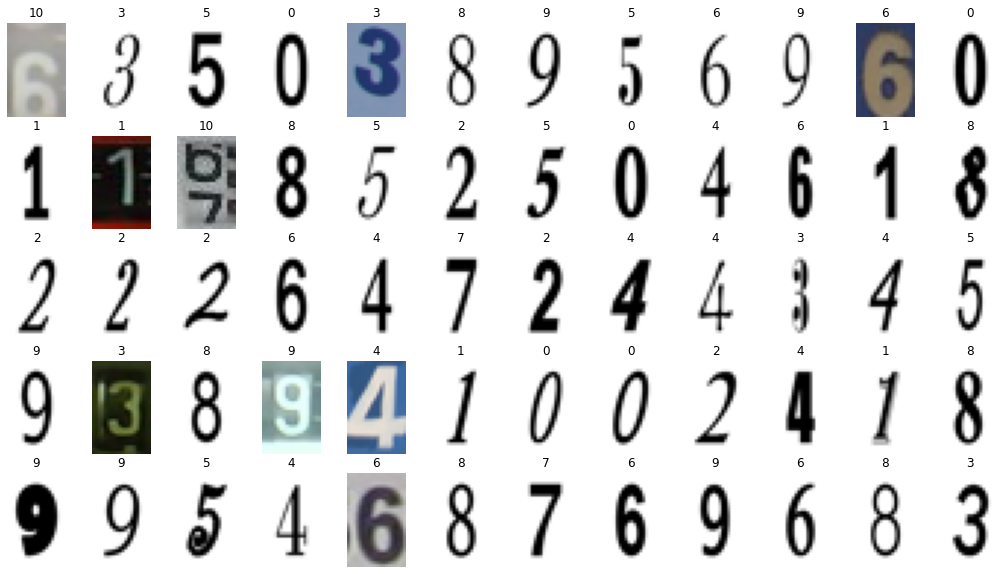

Train category count : [1011  960  926  920  935  920  906  916  884  903  395]
Test category count : [222 239 237 225 234 245 245 234 230 215  94]


In [6]:
# load all 3 datasets 
# the ziffer dataset will be used multiple times
x_ziffer_data, y_ziffer_data = ziffer_data([], [], nb_classes=nb_classes)
x_ziffer_data =  np.array(x_ziffer_data)
y_ziffer_data = np.array(y_ziffer_data).reshape(-1)
x_ziffer_data, y_ziffer_data = shuffle(x_ziffer_data, y_ziffer_data)
x_ziffer_train, x_ziffer_test, y_ziffer_train, y_ziffer_test = train_test_split(x_ziffer_data, y_ziffer_data, test_size=Training_Percentage)
print("Ziffer  images: ", y_ziffer_data.size)
print("Ziffer category count :", np.bincount(y_ziffer_data))

# th char74k dataset will be only used to lean numbers at first step
x_data, y_data = eng_char74k_numbers([], [])
x_data, y_data = font_char74k_numbers(x_data, y_data)
x_data =  np.array(x_data)
y_data = np.array(y_data).reshape(-1)
x_data, y_data = shuffle(x_data, y_data)

# Split train and validation data 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

# add ziffer-train/test data and shuffle again
x_train = np.concatenate((x_train, x_ziffer_train))
y_train = np.concatenate((y_train, y_ziffer_train))
x_test = np.concatenate((x_test, x_ziffer_test))
y_test = np.concatenate((y_test, y_ziffer_test))
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)
print("First step images (train/test): ", y_train.size, y_test.size)


plot_dataset(x_train, y_train)
print("Train category count :", np.bincount(y_train))
print("Test category count :", np.bincount(y_test))


### Define the model


#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "sparse_categorical_crossentropy" is choosen, as it is a categories task
* It uses from_logits=True (same activation softmax but not defined in model)



In [7]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization


def get_post(x_in):
    x = LeakyReLU()(x_in)
    x = BatchNormalization()(x)
    return x

def get_block(x_in, ch_in, ch_out):
    x = Conv2D(ch_in,
               kernel_size=(1, 1),
               padding='same',
               use_bias=False)(x_in)
    x = get_post(x)

    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = get_post(x)
    x = MaxPool2D(pool_size=(2, 1),
                  strides=(2, 1))(x) # Separable pooling

    x = DepthwiseConv2D(kernel_size=(3, 1),
                        padding='same',
                        use_bias=False)(x)
    x = get_post(x)

    x = Conv2D(ch_out,
               kernel_size=(2, 1),
               strides=(1, 2),
               padding='same',
               use_bias=False)(x)
    x = get_post(x)

    return x


def Effnet(input_shape, nb_classes, include_top=True, weights=None, activation_top=None):
    x_in = Input(shape=input_shape)

    x = get_block(x_in, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        x = Dense(nb_classes, activation=activation_top)(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model



# input_shape (32,20,3)
# nb_classes mostly 11.
# activation_dense None, if from_logits=True, or softmax if from_logits=False
def CNN32C3C3C5_BN_DA(input_shape, nb_classes, activation_dense=None ):
    model = Sequential()

    model = Sequential()
    model._name='CNN32C3C3C5_BN_DA'
    model.add(Conv2D(32,kernel_size=3,input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32,kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32,kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))


    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(nb_classes, activation = activation_dense))
    return model

# input_shape (32,20,3)
# nb_classes mostly 11.
# activation_dense None, if from_logits=True, or softmax if from_logits=False
def CNN32_Basic(input_shape, nb_classes, activation_dense=None):
    model = Sequential()
    model._name='CNN32_Basic'
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(nb_classes, activation = activation_dense))
    return model

# input_shape (32,20,3)
# nb_classes mostly 11.
# activation_dense None, if from_logits=True, or softmax if from_logits=False
def CNN32_Basic_Dropout(input_shape, nb_classes, activation_dense=None):
    model = Sequential()
    model._name='CNN32_Basic_Dropout'
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(nb_classes, activation = activation_dense))
    return model

# input_shape (32,20,3)
# nb_classes mostly 11.
# activation_dense None, if from_logits=True, or softmax if from_logits=False
def CNN32(input_shape, nb_classes, conv=(32,64,64), dense=256, use_dropout=True, activation_dense=None):
    conv_str = '_'.join(map(str, conv))
    model = Sequential()
    model._name='CNN32_C_' + conv_str + "_D_" + str(dense)
    model.add(Conv2D(conv[0], (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    if (use_dropout):
        model.add(Dropout(0.1))
    model.add(Conv2D(conv[1], (3, 3), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    if (use_dropout):
        model.add(Dropout(0.1))
    model.add(Conv2D(conv[2], (3, 3), padding='same', activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    if (use_dropout):
        model.add(Dropout(0.4))
    model.add(Dense(dense,activation="relu"))
    if (use_dropout):
        model.add(Dropout(0.4))
    model.add(Dense(nb_classes, activation = activation_dense))
    return model

### Knowledge distillation

https://keras.io/examples/vision/knowledge_distillation/

We need a smaller model for the EdgeAI-device. So we using knowledge distillation. It trains a teacher and student model. First the teacher model. Later the student model with combine the knowlage of the teacher model on loss.

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results



In [9]:
# Model creation (for more output comment in summery and mflops)

teacher = CNN32C3C3C5_BN_DA(input_shape, nb_classes, activation_dense=None)
teacher._name = "Teacher_" + teacher._name
#student = CNN32(input_shape, nb_classes, conv=(32, 32, 64), dense=256, use_dropout=True, activation_dense=None)
student = Effnet(input_shape, nb_classes, activation_top=None)
student._name = "Student_" + student._name
current_model = CNN32(input_shape, nb_classes, conv=(32, 32, 64), dense=256, use_dropout=False, activation_dense=None)
# Clone student for later comparison
student_scratch = keras.models.clone_model(student)
student_scratch._name = "Student-scratch_" + student_scratch._name


# teacher model will later named model
teacher.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam", metrics = ["accuracy"])
#teacher.summary()
#print(f'Model {student._name} has MFLOPs :{get_flops(student)/1000000 }', )

# student scratch
student_scratch.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam", metrics = ["accuracy"])

student.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam", metrics = ["accuracy"])

current_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam", metrics = ["accuracy"])

# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller._name = student._name
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# student will represent by distiller-model
models = [teacher, student_scratch, distiller]



Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.

Invert added for the inverse (white on black) numbers on the gas and e-meters


(9676,)


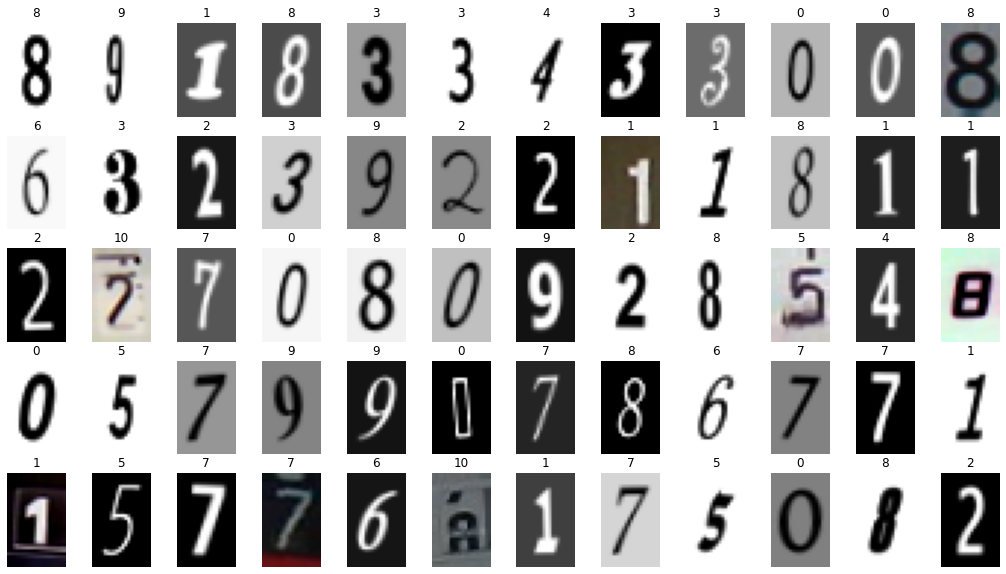

In [10]:
import cv2
import random

Batch_Size = 32
Shift_Range = 1
Brightness_Range = 0.5
Rotation_Angle = 5
ZoomRange = 0.2
ShearRange= 2

def invert(imagem):
    if (random.getrandbits(1)):
        return (255)-imagem
    else:
        return imagem
    

datagen = ImageDataGenerator(width_shift_range=Shift_Range, 
                             height_shift_range=Shift_Range,
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1, 1+ZoomRange],
                             rotation_range=Rotation_Angle,
                             channel_shift_range=1,
                             fill_mode='nearest',
                             shear_range=ShearRange,
                             preprocessing_function=invert)
print(y_train.shape)
train_iterator = datagen.flow(x_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(x_test, y_test, batch_size=Batch_Size)

plot_dataset_it(train_iterator)



2022-04-05 21:51:44.878384: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model Teacher_CNN32C3C3C5_BN_DA: Epochs=80, Train accuracy=0.99938, Validation accuracy=0.99750
All Zifferdata accuracy: 0.9918094277381897


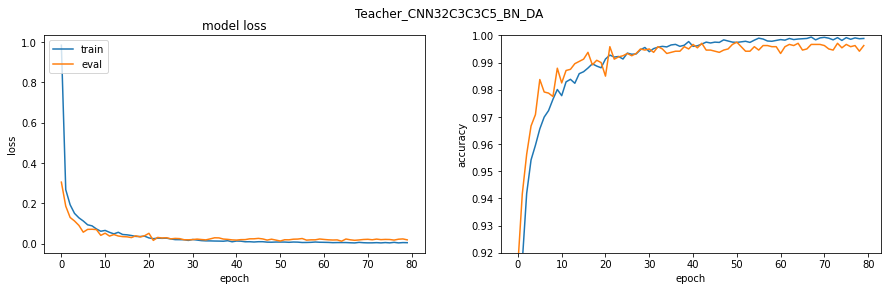

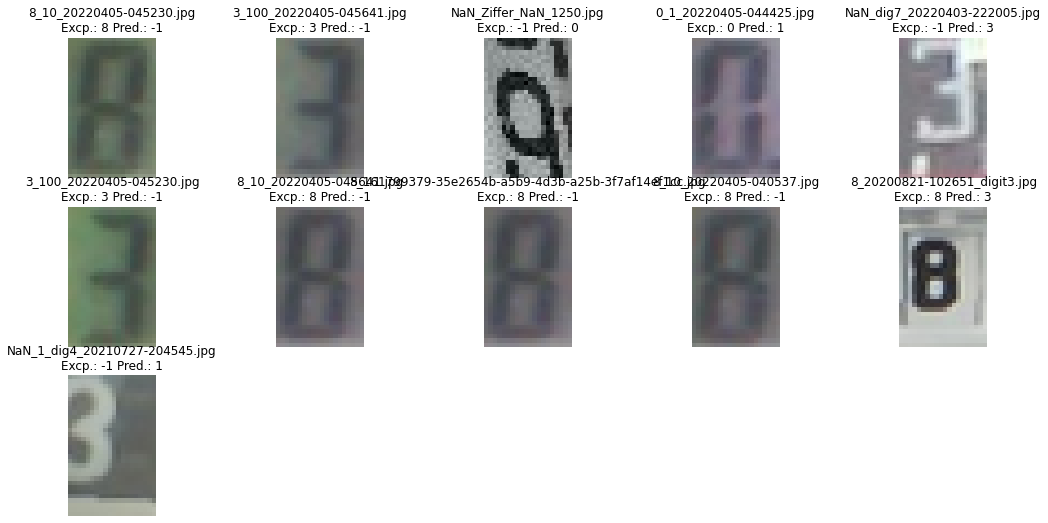

Model Student-scratch_Student_model: Epochs=80, Train accuracy=1.00000, Validation accuracy=0.99417
All Zifferdata accuracy: 0.985107958316803


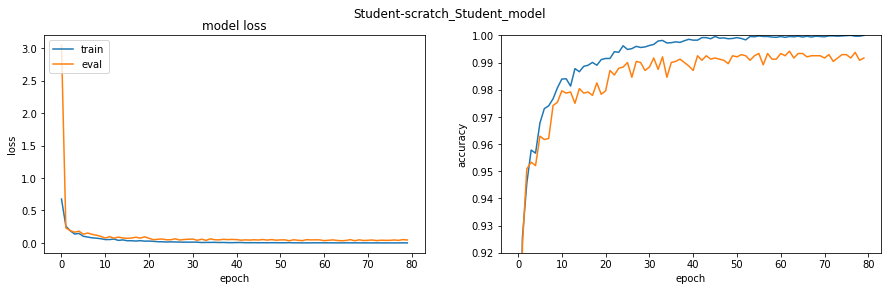

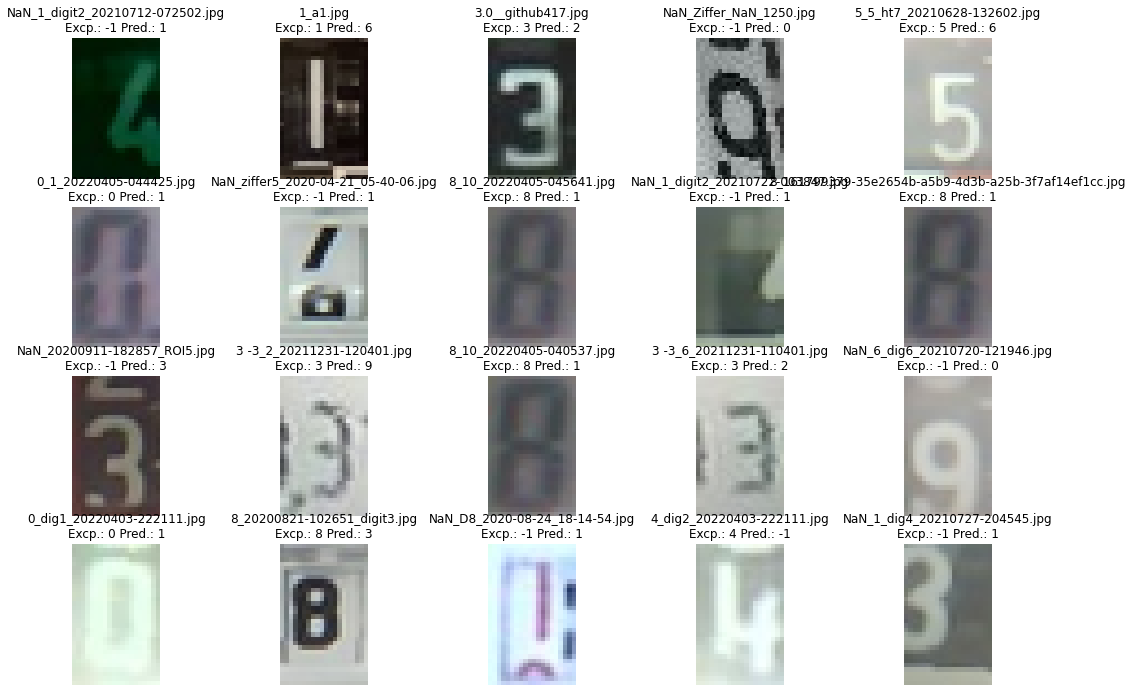

Model Student_model: Epochs=80, Train accuracy=1.00000, Validation accuracy=0.99625
All Zifferdata accuracy: 0.9858525991439819


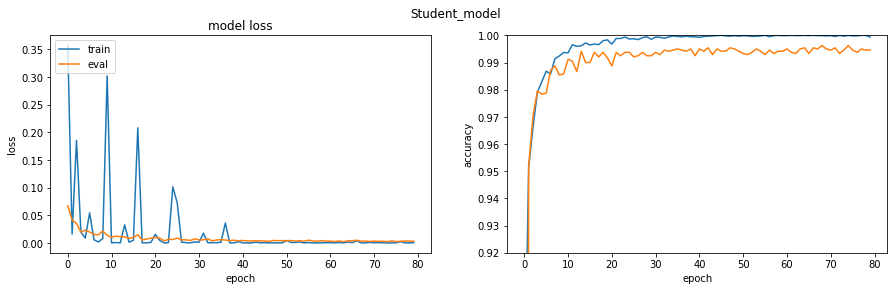

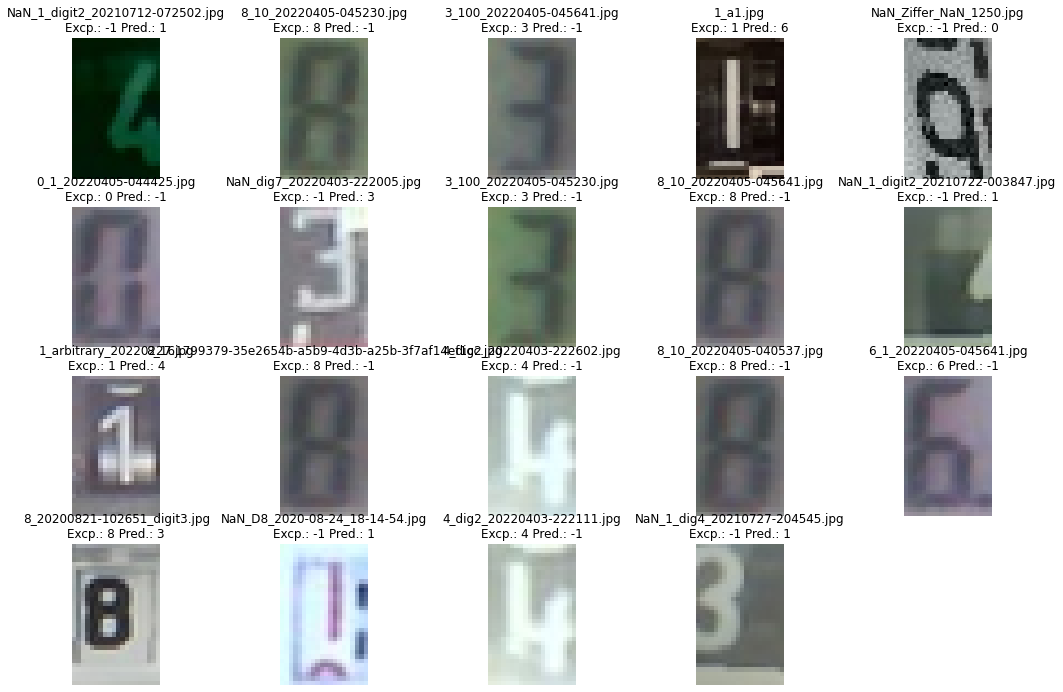

In [11]:
# train models
from keras.callbacks import LearningRateScheduler

# reduzing the learning rate every epoch 
annealer = LearningRateScheduler(lambda x: 2e-3 * 0.95 ** x, verbose=0)

history = [0] * len(models)

for i, model in enumerate(models):
    history[i] = model.fit(train_iterator, 
                validation_data = validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz, 
                steps_per_epoch=len(y_train)//Batch_Size,
                validation_steps=len(y_test)//Batch_Size,
                callbacks=[annealer], 
                verbose=0)

    printMaxHistory(history=history[i], modelname=model._name)
    
    # eval model on test, plot accuracy and eval on zifferdata
    eval_model(model=model, history=history[i])

#plot_val_acc(models, history)


### Learning result
 
* Visualization of the validation results of teacher and student model. 


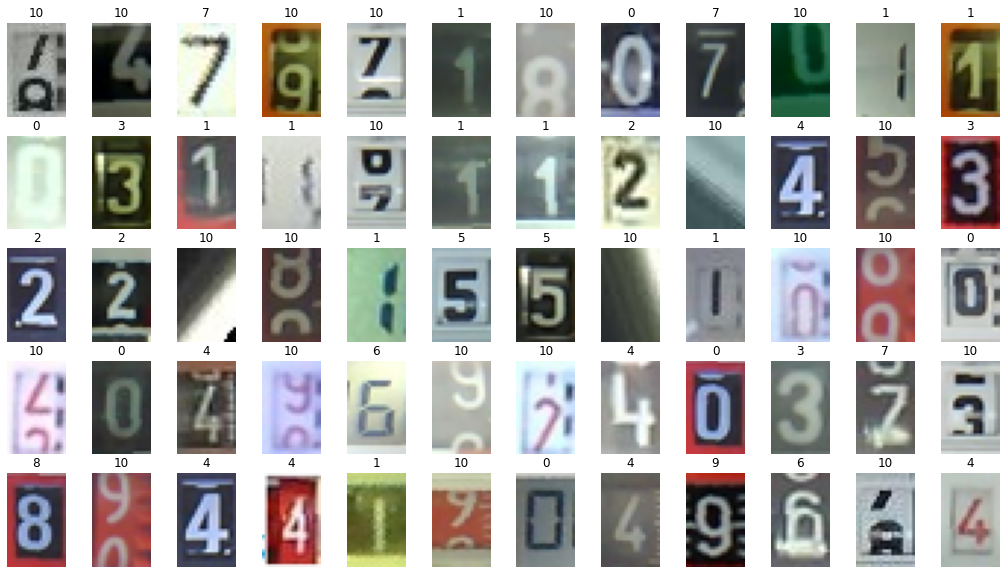

Model Teacher_CNN32C3C3C5_BN_DA: Epochs=100, Train accuracy=1.00000, Validation accuracy=0.98828
All Zifferdata accuracy: 0.9910647869110107


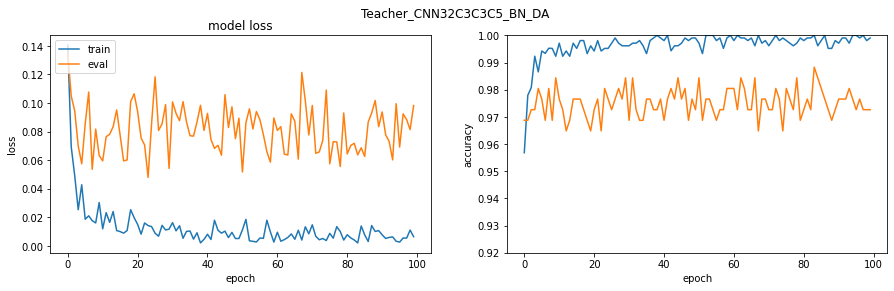

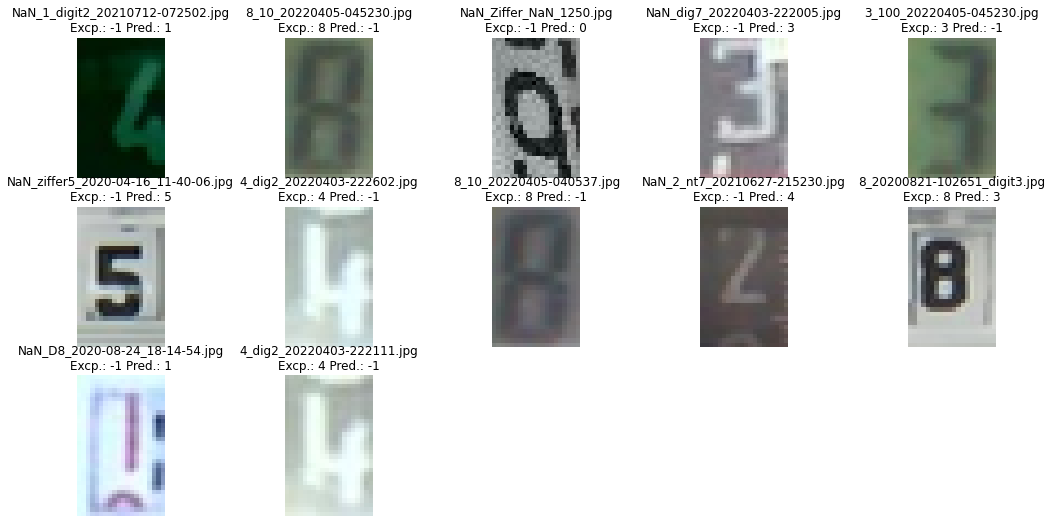

Model Student-scratch_Student_model: Epochs=100, Train accuracy=1.00000, Validation accuracy=0.97656
All Zifferdata accuracy: 0.9858525991439819


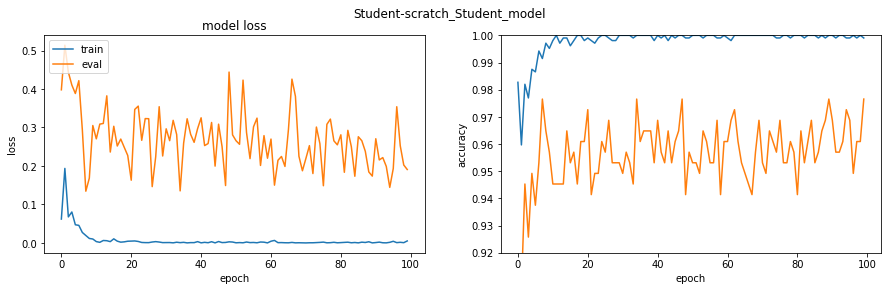

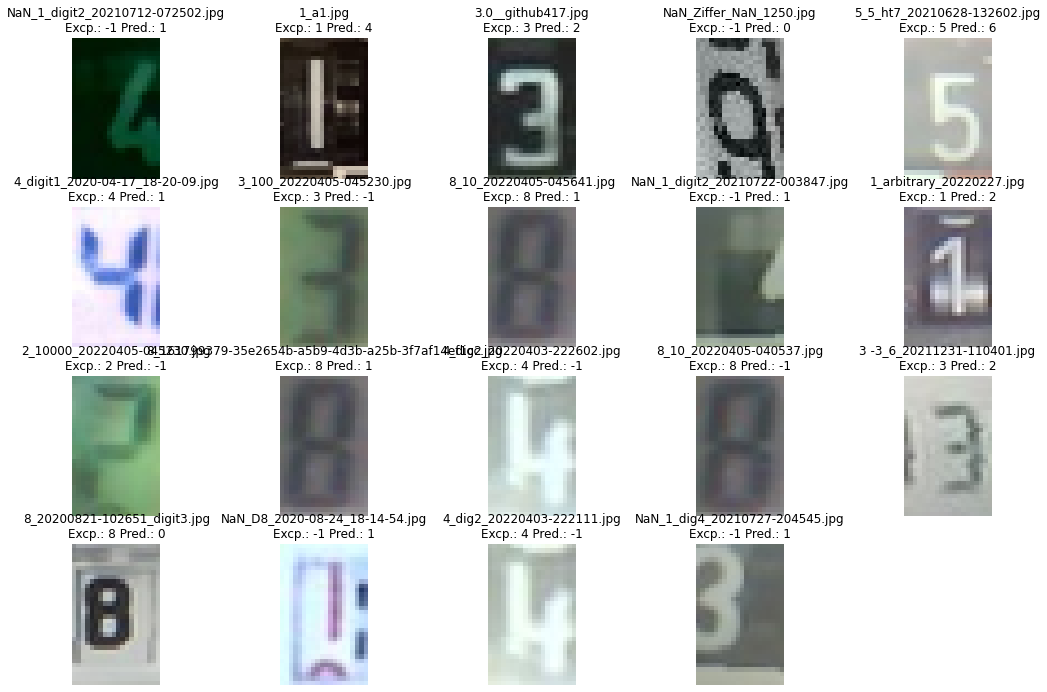

Model Student_model: Epochs=100, Train accuracy=1.00000, Validation accuracy=0.98438
All Zifferdata accuracy: 0.9888309836387634


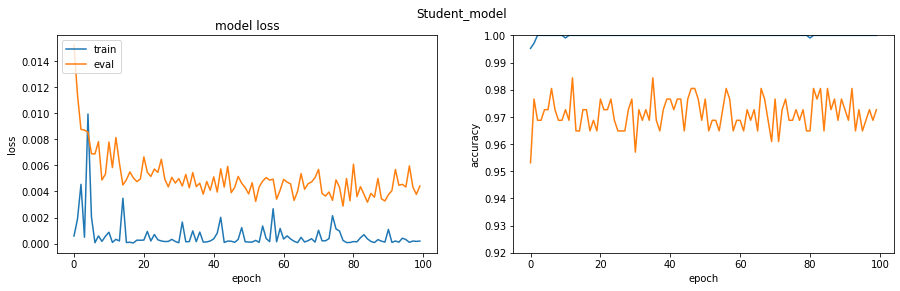

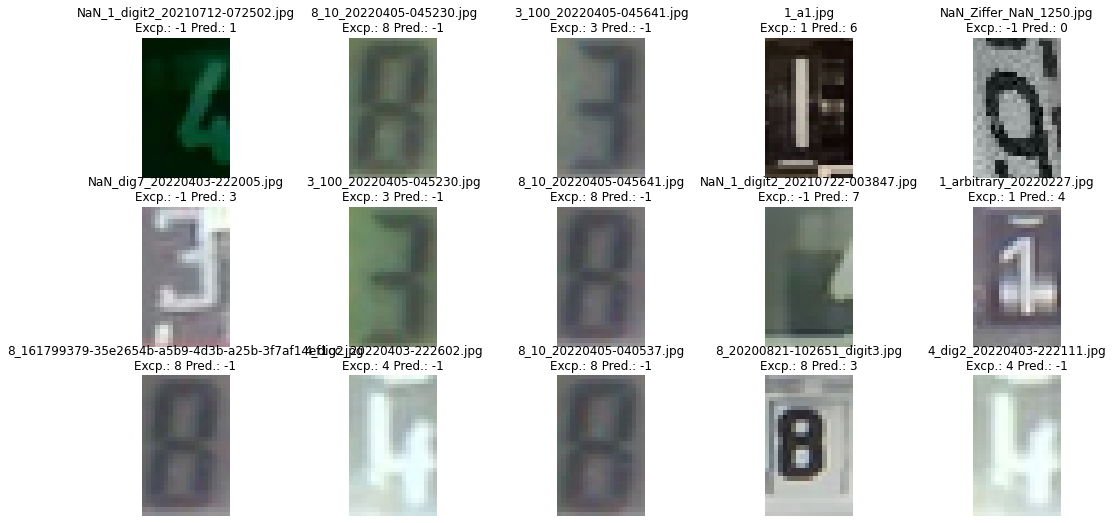

In [12]:
## load ziffer data with NaN-class
# Split train and validation data 
x_train, x_test, y_train, y_test = x_ziffer_train, x_ziffer_test, y_ziffer_train, y_ziffer_test
plot_dataset(x_train, y_train)

# train the models again
train_iterator = datagen.flow(x_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(x_test, y_test, batch_size=Batch_Size)


# because of the small dataset we need more epoches to learn
Epoch_Anz = 100
#(back to normal rate. learning rate was to low)
annealer = LearningRateScheduler(lambda x: 5e-4 * 0.95 ** x, verbose=0)

for i, model in enumerate(models):
    history[i] = model.fit(train_iterator, 
                validation_data = validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz, 
                steps_per_epoch=len(y_train)//Batch_Size,
                validation_steps=len(y_test)//Batch_Size,
                callbacks=[annealer], 
                verbose=0)
    
    printMaxHistory(history=history[i], modelname=model._name)
    

    # eval model on test, plot accuracy and eval on zifferdata
    eval_model(model, history[i])


#plot_val_acc(models, history)    

In [7]:
from keras.callbacks import LearningRateScheduler,EarlyStopping
  
callbacks = [LearningRateScheduler(lambda x: 5e-4 * 0.95 ** x, verbose=0)]
 
_callbacks = [EarlyStopping(monitor='student_loss', patience=3)]
_callbacks.extend(callbacks)

print(_callbacks)


[<keras.callbacks.EarlyStopping object at 0x110ec5c10>, <keras.callbacks.LearningRateScheduler object at 0x110f27d00>]


### Comparisation against current model training

The current model training stores the model and history and trains every time on it. 
But the train and test data every will be shuffled every training. So every image is a train data over the time and the model will be much overfitted.

We can see the validation accuracy is much lower than train accuracy.

Another problem is, that the model does not use Dropout. So after a few epochs the training accuracy is much higher than the validation accuracy. 

Model CNN32_C_32_32_64_D_256: Epochs=100, Train accuracy=1.00000, Validation accuracy=0.97656
All Zifferdata accuracy: 0.97915118932724


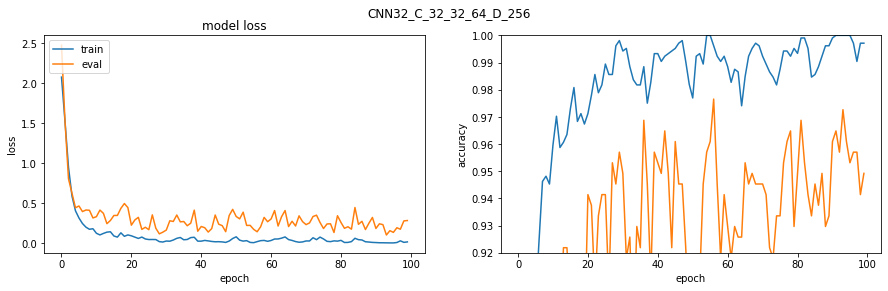

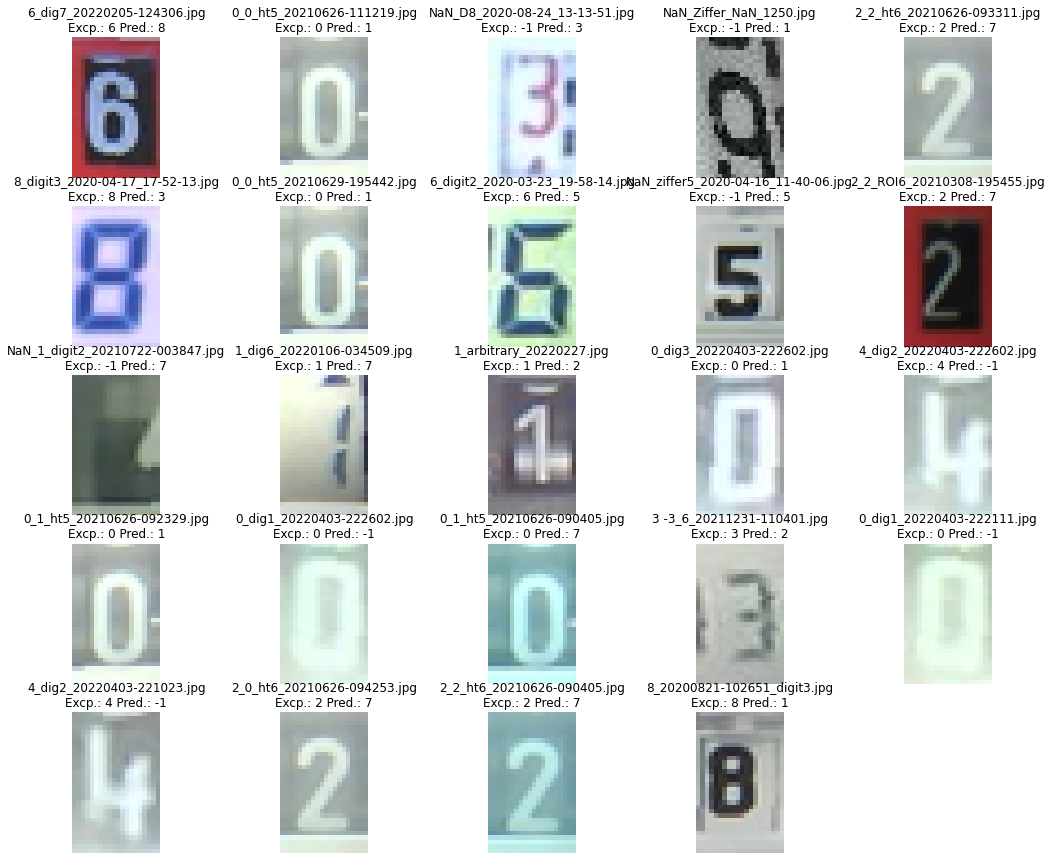

In [13]:
# current model (small-v2) training as comparisation

cur_hiso = current_model.fit(train_iterator, 
                validation_data = validation_iterator, 
                batch_size=Batch_Size, 
                epochs = 100, 
                steps_per_epoch=len(y_train)//Batch_Size,
                validation_steps=len(y_test)//Batch_Size,
                verbose=0)
printMaxHistory(history=cur_hiso, modelname=current_model._name)



# eval model on test, plot accuracy and eval on zifferdata
eval_model(model=current_model, history=cur_hiso)



## Pruning an Quantization

After model is trained fine it will now pruned and quantized for the EdgeAI-device.

Naturally we use the distilated student model for pruning and quantization.

It will quanized to uint8, means 8bit. It could be enhanced by input/ouput quantization to uint8, but the edgeAI-code must be changed. 

In [14]:
####### Pruning
### see https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras
print("Pruning...")

import tempfile
import tensorflow_model_optimization as tfmot

# used for check difference to pruning
_, baseline_model_accuracy = student.evaluate(
    x_test, y_test, verbose=0)

# beware only validation ziffer data evaluated. Not all ziffer data like above
print('Baseline test accuracy:', baseline_model_accuracy)


prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(student, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   x_train, y_train, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
#model_for_export.summary()

####### End Pruning

##### Quantization of the pruned model
FileName = TFliteNamingAndVersion + "q.tflite"

converter    = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

def representative_dataset():
    for n in range(x_train[0].size):
      data = np.expand_dims(x_train[5], axis=0)
      yield [data.astype(np.float32)]
         
converter2 = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
# Ensure that if any ops can't be quantized, the converter throws an error
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
#converter2.inference_input_type = tf.uint8
#converter2.inference_output_type = tf.uint8
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)




Pruning...
Baseline test accuracy: 0.9665427207946777


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  threshold = self.add_variable(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.pruning_step = self.add_variable(


31/31 [==============================] - 7s 80ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0461 - val_accuracy: 0.9907
Baseline test accuracy: 0.9665427207946777
Pruned test accuracy: 0.9981378316879272


2022-04-05 22:23:01.447020: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpqhf_bb0j/assets


2022-04-05 22:23:12.044344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-05 22:23:12.044360: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp1apzagez/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp1apzagez/assets
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-04-05 22:23:24.296344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-05 22:23:24.296359: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


194776

### Check the final tflite model by hand

* The pruned and quantized student model will be evaluated. This are the results we get on the edgeAI device
* All pictures of the complete ziffer data set will be checked and all false predicted are printed out

accuracy of all zifferdata:  0.9947877885331348


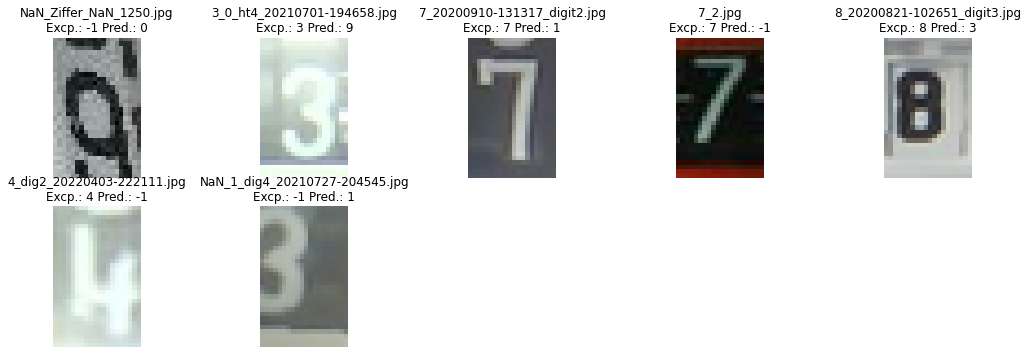

In [15]:
files = ziffer_data_files()

fig = plt.figure(figsize=(18, 15))
columns = 5
rows = 5
index = 0

# we use the tflite model
interpreter = tf.lite.Interpreter(model_path="kndq.tflite")
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile).resize((20,32))
    test_image = np.array(image_in, dtype=np.float32)
    img = np.reshape(test_image,[1,32,20,3])
    
    interpreter.set_tensor(input_index, img)
    # Run inference.
    interpreter.invoke()
    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.get_tensor(output_index)
    classesp = output[0]
    #classesp = model.predict(img)[0]
    classes = np.argmax(output[0])
    if classes == 10: 
        classes = -1
    if str(classes) != str(expected_class):
        index = index + 1
        if index < (columns*rows):
            fig.add_subplot(rows, columns, index)
            plt.title(base + "\nExcp.: " +   str(expected_class) + " Pred.: " + str(classes))  # set title
            plt.imshow(test_image.astype(np.uint8))
            plt.axis("off")
        

print("accuracy of all zifferdata: ", (len(files)-index)/len(files))
plt.show()

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.